In [ ]:
 ! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atharvamahadeokar211","key":"cf5126a42d04247387bf34fada3d4a9a"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bingazuran/nsfwsfwecd

100% 2.79G/2.80G [02:28<00:00, 18.9MB/s]
100% 2.80G/2.80G [02:28<00:00, 20.3MB/s]


In [ ]:
!unzip /content/nsfwsfwecd.zip

Archive:  /content/nsfwsfwecd.zip
  inflating: DataSet/test/nsfw/0018f3e0-9446-4567-9917-ff5b46ffa20b.jpg  
  inflating: DataSet/test/nsfw/005c70bc-b0e4-428f-b531-851adb5a4ecd.jpg  
  inflating: DataSet/test/nsfw/005f5a5a-42d2-4476-a5bc-1fe22b6dddfd.jpg  
  inflating: DataSet/test/nsfw/005f8b99-4ee4-4980-8847-e0ce84b306f0.jpg  
  inflating: DataSet/test/nsfw/006d6dc0-afd1-48b7-b8b7-73dc640e725f.jpg  
  inflating: DataSet/test/nsfw/00a68f35-f373-4f73-b862-6f3fb10f6bb4.jpg  
  inflating: DataSet/test/nsfw/010a5223-ef1b-448f-9387-04d0b68647dc.jpg  
  inflating: DataSet/test/nsfw/02c4548e-98ca-4526-bdca-b746b8b7b33f.jpg  
  inflating: DataSet/test/nsfw/02d1a84a-460b-42bc-b4bb-0f9a12a3b6fe.jpg  
  inflating: DataSet/test/nsfw/03aa8df7-11e8-4ac9-a6eb-258bc4a0bfe2.jpg  
  inflating: DataSet/test/nsfw/03adfd36-8578-45b6-993c-c23297062148.jpg  
  inflating: DataSet/test/nsfw/03dc9f12-6068-4e4c-9095-d38cd246f4b5.jpg  
  inflating: DataSet/test/nsfw/04b65d2f-8658-4bdd-8889-9b40d667bcb0.jpg  
  in

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
def resize_image(path):
    # Load the image using TensorFlow
    img = tf.keras.preprocessing.image.load_img(
        path,
        target_size=(224, 224),
        interpolation='bicubic'
    )

    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)


    # Save the resized image back to the same path
    img = tf.keras.preprocessing.image.array_to_img(img_array)
    img.save(path)

In [ ]:
import os

def resize_images_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                resize_image(path)

resize_images_in_directory('/content/DataSet')

In [ ]:
PATH='/content/DataSet'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2004 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [ ]:
# class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 57ms/step - loss: 0.7109 - accuracy: 0.5483


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.50


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 75ms/step - loss: 0.6401 - accuracy: 0.6257 - val_loss: 0.5592 - val_accuracy: 0.6708
Epoch 2/10
63/63 [==============================] - 5s 71ms/step - loss: 0.4538 - accuracy: 0.7784 - val_loss: 0.4709 - val_accuracy: 0.7401
Epoch 3/10
63/63 [==============================] - 4s 66ms/step - loss: 0.3737 - accuracy: 0.8283 - val_loss: 0.4106 - val_accuracy: 0.7822
Epoch 4/10
63/63 [==============================] - 5s 74ms/step - loss: 0.3180 - accuracy: 0.8598 - val_loss: 0.3751 - val_accuracy: 0.8144
Epoch 5/10
63/63 [==============================] - 4s 66ms/step - loss: 0.2747 - accuracy: 0.8847 - val_loss: 0.3476 - val_accuracy: 0.8366
Epoch 6/10
63/63 [==============================] - 6s 91ms/step - loss: 0.2474 - accuracy: 0.9022 - val_loss: 0.3327 - val_accuracy: 0.8416
Epoch 7/10
63/63 [==============================] - 4s 66ms/step - loss: 0.2267 - accuracy: 0.9132 - val_loss: 0.3277 - val_accuracy: 0.8416
Epoch 8/10
63

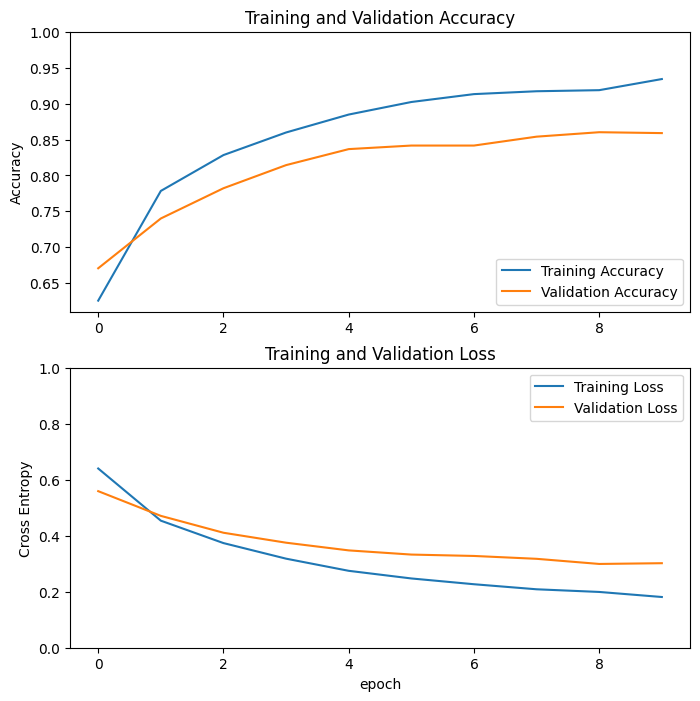

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 18s 105ms/step - loss: 0.1319 - accuracy: 0.9531 - val_loss: 0.2724 - val_accuracy: 0.8923
Epoch 11/20
63/63 [==============================] - 6s 90ms/step - loss: 0.0877 - accuracy: 0.9661 - val_loss: 0.2845 - val_accuracy: 0.8614
Epoch 12/20
63/63 [==============================] - 6s 92ms/step - loss: 0.0720 - accuracy: 0.9741 - val_loss: 0.2989 - val_accuracy: 0.8861
Epoch 13/20
63/63 [==============================] - 7s 107ms/step - loss: 0.0671 - accuracy: 0.9731 - val_loss: 0.3040 - val_accuracy: 0.8812
Epoch 14/20
63/63 [==============================] - 6s 86ms/step - loss: 0.0582 - accuracy: 0.9775 - val_loss: 0.3110 - val_accuracy: 0.8874
Epoch 15/20
63/63 [==============================] - 6s 90ms/step - loss: 0.0522 - accuracy: 0.9795 - val_loss: 0.3557 - val_accuracy: 0.8775
Epoch 16/20
63/63 [==============================] - 5s 85ms/step - loss: 0.0412 - accuracy: 0.9885 - val_loss: 0.4065 - val_accuracy: 0.8874
Epo

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

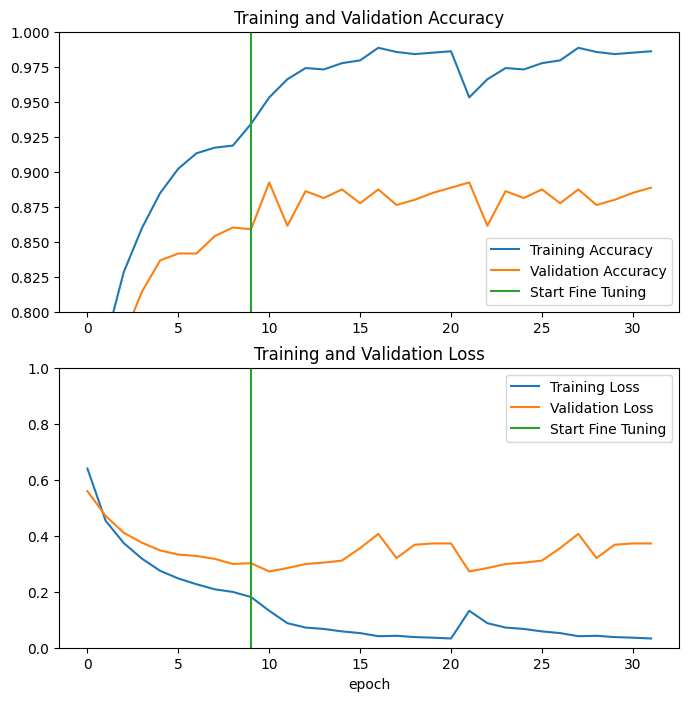

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 54ms/step - loss: 0.3694 - accuracy: 0.8906
Test accuracy : 0.890625


In [ ]:
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

ValueError: ignored

In [ ]:
from PIL import Image
import numpy as np
def predict_one(path):
  image = Image.open(path)
  image = image.resize((224, 224), resample=Image.BILINEAR)
  image_array = np.array(image)
  image_array = np.expand_dims(image_array, axis=0)
  predictions = model.predict(image_array)
  result=1 / (1 + np.exp(-predictions))
  return result



In [ ]:
print(predict_one('/content/DataSet/test/sfw/005dc339-be1b-418e-ac61-21cfdb1695f7.jpg'))

1/1 [==============================] - 0s 23ms/step
[[0.9994691]]


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('obscenity_image.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
tflite_model_path = '/content/obscenity_image.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_one_tflite(path):
  # Load and preprocess the image
  image = Image.open(path)
  image = image.resize((224, 224), resample=Image.BILINEAR)
  image_array = np.array(image)
  image_array = np.expand_dims(image_array, axis=0)

  # Set input tensor
  input_tensor = np.array(image_array, dtype=np.float32)
  interpreter.set_tensor(input_details[0]['index'], input_tensor)

  # Perform inference
  interpreter.invoke()

  # Get output tensor
  output_tensor = interpreter.get_tensor(output_details[0]['index'])

  # Convert output tensor to probabilities
  result = 1 / (1 + np.exp(-output_tensor))
  return result

In [ ]:
%%time
print(predict_one_tflite('/content/DataSet/train/sfw/aaron-mello-137671-unsplash.jpg'))

[[0.999742]]
CPU times: user 26 ms, sys: 920 µs, total: 27 ms
Wall time: 76.6 ms
